In [1]:
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
####  Mouse C3KO-RichLi snRNA
####  2023-05-16 by Yi Zhao (Texas Heart Institute, US)
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
####  Initiate  ####
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~----
Ver <- '0'
Step <- 'PART02_Merge'
Project <- '2023_neoc3ko_rli'

Code_dir <- paste0('/Volumes/shire/project/', Project, '/code/mouse_v', Ver, '/')

source(Sys.readlink(paste0(Code_dir, 'src/bioinformatics.R')))
source(Sys.readlink(paste0(Code_dir, 'src/scRNAseq.R')))
source(Sys.readlink(paste0(Code_dir, 'src/scATACseq.R')))
source(paste0(Code_dir, 'mouse_v', Ver, '.helper_functions.R'))

InitiateProject('Rivendell', Ver, Step, 'mouse', Project, 'shire')
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [13]:
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
####  Global Functions  ####
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~----
CheckMerged <- function(srt, reduction = 'umap', assay = 'RNA'){
        srt@reductions[[1]] <- srt@reductions[[reduction]]
        p1 <- DimPlot2(srt, group.by = 'sample', reduction = reduction, split.by = 'sample',
                      cols = mycol_10, label = F, pt.size = 0.1, ncol = 7) &
                guides(col = guide_legend(ncol = 1)) &
                theme(aspect.ratio = 1)
        p3 <-  DimPlot2(srt, group.by = 'genotype', reduction = reduction,
                       cols = mycol_10, label = F, pt.size = 0.1) +
                labs(x = "UMAP 1", y = "UMAP 2",
                     title = paste0(ncol(srt), " Cells x ", nrow(srt), " Genes")) +
                guides(col = guide_legend(ncol = 1))
        p <- VlnPlot2(srt,
                      features = paste0(c('nFeature_', 'nCount_', 'pct_mito_'), assay), group.by = 'sample')
        p4 <- wrap_plots(list((
                p[[1]] + theme(axis.text.x = element_blank())),
                (p[[2]] + theme(axis.text.x = element_blank())),
                p[[3]]), ncol = 1) & theme(aspect.ratio = 0.5)
        p5 <- FeaturePlot2(srt,
                           reduction = reduction,
                           features = intersect(markers_lvl1_min, rownames(srt)),
                           ncol = ceiling(L(intersect(markers_lvl1_min, rownames(srt))) / 4))
        return(list(
                p1,
                # p2,
                p3,
                p4,
                p5
        ))
}

Preprocess <- function(srt_obj, assay = 'RNA', ...) {
        srt.out <- srt_obj |>
                NormalizeData(verbose = F) |>
                CellCycleScoring(s.features = s.genes, g2m.features = g2m.genes, set.ident = F) |>
                PercentageFeatureSet(pattern = '^mt-', col.name = paste0('pct_mito_', assay), assay = assay)
        srt.out@meta.data[, paste0('pct_mito_', assay)][is.nan(srt.out@meta.data[, paste0('pct_mito_', assay)])] <- 0
        return(srt.out)
}
SCTransform.my <- function(srt_obj, assay = 'RNA', ...){
        srt.out <- srt_obj |>
                SCTransform(assay = assay,
                            method = "glmGamPoi",
                            seed.use = 505,
                            return.only.var.genes = F,
                            vars.to.regress = c(paste0('nFeature_', assay),
                                                paste0('nCount_', assay),
                                                paste0('pct_mito_', assay),
                                                'S.Score',
                                                'G2M.Score'),
                            ...)
        return(srt.out)
}

RunUMAP.my <- function(srt_obj, var.toal = 0.75, haromize.by, assay, ...){
        srt.out <- RunPCA(srt_obj, seed.use = 505, assay = assay)
        dimN <- FindDimNumber(srt_obj = srt.out, var.toal = var.toal, reduction = 'pca')
        srt.out <- RunUMAP(srt.out, dims = 1:dimN, seed.use = 505) |>
                RunHarmony(group.by.vars = haromize.by, assay.use = assay)
        dimN <- FindDimNumber(srt_obj = srt.out, var.toal = var.toal, reduction = 'harmony')
        srt.out <- RunUMAP(srt.out, dims = 1:dimN, seed.use = 505, reduction = 'harmony',
                           reduction.name = 'hmn_umap', reduction.key = 'hmnumap_', ...)
        return(srt.out)
}
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~----

In [3]:
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
####  Load sample metadata  ####
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~----
sample_meta.df <- read.csv(paste0(Docu_dir, 'mouse_sample_meta.csv'))
studies <- U(sample_meta.df$study)
names(studies) <- U(sample_meta.df$study_id)
studies_cellbender <- studies[studies %in% sample_meta.df$study[sample_meta.df$platform %in% c('10X', 'Drop-seq')]]
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [4]:
studies

P01 
"2023_NeoC3KO_RLi"

In [8]:
####  Merge GEX  ####
merge.srt <- readRDS('individual/P01.2023_NeoC3KO_RLi.cbn.srt.rds')

#merge.srt <- merge(x = gex.srt.list[[1]], y = gex.srt.list[2:8])


In [9]:
merge.srt

An object of class Seurat 
27993 features across 116116 samples within 1 assay 
Active assay: RNA (27993 features, 0 variable features)

In [ ]:
#DefaultAssay(merge.srt) <- 'CBN'
#merge.srt <- RenameAssays(merge.srt, c('CBN' = 'RNA'))

####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#saveRDS(merge.srt, 'integrated/PART02.merged.srt.rds')
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

####  Restart the kernel and run from here  ####
#merge.srt <- readRDS('integrated/PART02.merged.srt.rds')

In [11]:
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
####  Visualize data  ####
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~----
## Preprocess
merge.srt$pct_mito <- NULL
assay <- 'RNA'
merge.srt <- Preprocess(merge.srt,assay)
merge.srt <- FindVariableFeatures(merge.srt) |> ScaleData()

merge.srt <- RunUMAP.my(merge.srt, assay = assay, var.toal = 0.75, haromize.by = 'sample')
gc()

Centering and scaling data matrix

PC_ 1 
Positive:  Rgs6, Chrm2, Gm12295, Fstl4, Ankrd1, Gm13481, Kcnj3, Agbl4, Gm41505, Myl2 
	   Mpped2, Cdh20, Xirp2, Slc24a2, Lrrc3b, Ddc, Hs3st5, Tsix, Pacrg, 1700042O10Rik 
	   Grm1, Gm16168, Wdr72, Nppb, Astn2, Fgf14, Gm13601, Mylk4, Erc2, Xist 
Negative:  Sparc, mt-Atp6, mt-Co2, Gm42418, mt-Co1, mt-Cytb, mt-Nd4, mt-Nd1, mt-Nd2, Col1a2 
	   Col3a1, Timp2, Msln, Upk3b, Crip1, Rpl23, Dcn, Col1a1, Rps8, Ptma 
	   Rarres2, Hsp90ab1, Gpm6a, Pkhd1l1, mt-Nd3, Rps3, Efemp1, Fth1, Rpl13, Upk1b 
PC_ 2 
Positive:  Bicc1, Sulf1, Sox5, Meg3, Gpc3, Slit3, Sema3d, Arhgap28, Tenm3, Thsd4 
	   Npas3, Efna5, Cdh11, Abi1, Col5a2, Fbxl7, Gulp1, Cdon, Syne2, Gpr39 
	   Wdr17, Sema3c, Gpm6a, Plxdc2, Zbtb7c, Sema5a, Adgrd1, Fndc1, Egfr, Kcnt2 
Negative:  Mb, Fabp3, Atp5g1, Myl3, Cox6c, Actc1, Myl2, Cox4i1, Atp5o, Tnni3 
	   Gapdh, Atp5g3, Uqcr11, Ndufa4, Cox6b1, Atp5h, Slc25a4, Uqcrq, Cox5b, Cox6a2 
	   Atp5e, Cox7a2, Cox5a, Uqcrh, Atp5j, Atp5j2, Uqcrb, Cycs, Atp5b, Nd

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,14976827,799.9,27528652,1470.2,NA,27528652,1470.2
Vcells,1711296332,13056.2,3154374305,24066.0,131072,2952284370,22524.2


In [14]:
## Plot for visual inspections
plot.list <- CheckMerged(merge.srt, reduction = 'umap', assay = assay)
PlotPDF('01.1.merge_cellbender_consensus.quick_check.split_dim', 20, 20)
plot.list[[1]]
dev.off()
PlotPDF('01.2.merge_cellbender_consensus.quick_check.dim', 10, 10)
plot.list[[2]]
dev.off()
PlotPDF('01.3.merge_cellbender_consensus.quick_check.vln', 10, 10)
plot.list[[3]]
dev.off()
PlotPDF('01.4.merge_cellbender_consensus.quick_check.feature', 20, 20)
plot.list[[4]]
dev.off()

## Plot for visual inspections
plot.list <- CheckMerged(merge.srt, reduction = 'hmn_umap', assay = assay)
PlotPDF('02.1.merge_cellbender_consensus.quick_check.split_dim', 20, 20)
plot.list[[1]]
dev.off()
PlotPDF('02.2.merge_cellbender_consensus.quick_check.dim', 10, 10)
plot.list[[2]]
dev.off()
PlotPDF('02.3.merge_cellbender_consensus.quick_check.feature', 20, 20)
plot.list[[4]]
dev.off()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To di

pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To di

pdf 
  2

pdf 
  2

pdf 
  2

In [40]:
merge.srt$group1 <- factor('nn', levels = c('wt_p2m1','wt_p2m2','wt_p2s1','wt_p2s2',
                                              'c3_p2m1','c3_p2m2','c3_p2s1','c3_p2s2'))
merge.srt$group1[merge.srt$sample == 'P01_S001'] <- 'wt_p2m1'
merge.srt$group1[merge.srt$sample == 'P01_S002'] <- 'wt_p2m2'
merge.srt$group1[merge.srt$sample == 'P01_S003'] <- 'wt_p2s1'
merge.srt$group1[merge.srt$sample == 'P01_S004'] <- 'wt_p2s2'
merge.srt$group1[merge.srt$sample == 'P01_S005'] <- 'c3_p2m1'
merge.srt$group1[merge.srt$sample == 'P01_S006'] <- 'c3_p2m2'
merge.srt$group1[merge.srt$sample == 'P01_S007'] <- 'c3_p2s1'
merge.srt$group1[merge.srt$sample == 'P01_S008'] <- 'c3_p2s2'
#merge.srt$group1 <- factor(merge.srt$group1, levels = c('wt_p2m1','wt_p2m2','wt_p2s1','wt_p2s2','c3_p2m1','c3_p2m2','c3_p2s1','c3_p2s2'))

In [41]:
merge.srt$group2 <- factor('nn', levels = c('wt_p2m', 'wt_p2s', 'c3_p2m', 'c3_p2s'))
merge.srt$group2[merge.srt$sample == 'P01_S001'] <- 'wt_p2m'
merge.srt$group2[merge.srt$sample == 'P01_S002'] <- 'wt_p2m'
merge.srt$group2[merge.srt$sample == 'P01_S003'] <- 'wt_p2s'
merge.srt$group2[merge.srt$sample == 'P01_S004'] <- 'wt_p2s'
merge.srt$group2[merge.srt$sample == 'P01_S005'] <- 'c3_p2m'
merge.srt$group2[merge.srt$sample == 'P01_S006'] <- 'c3_p2m'
merge.srt$group2[merge.srt$sample == 'P01_S007'] <- 'c3_p2s'
merge.srt$group2[merge.srt$sample == 'P01_S008'] <- 'c3_p2s'
#merge.srt$group2 <- factor(merge.srt$group2, levels = c('wt_p2m', 'wt_p2s', 'c3_p2m', 'c3_p2s'))

In [43]:
Table(merge.srt$group1, merge.srt$sample)
Table(merge.srt$group1, merge.srt$group2)

df1 <- CountCellBarPlot(merge.srt, group.var = 'group1', stack.var = 'age')$data
df2 <- CountCellBarPlot(merge.srt, group.var = 'group1', stack.var = 'sex')$data
df <- dplyr::inner_join(df1, df2, by = 'GroupVar')
df$StackVar.x <- factor(df$StackVar.x, levels = sort(U(df$StackVar.x)))

         
          P01_S001 P01_S002 P01_S003 P01_S004 P01_S005 P01_S006 P01_S007
  wt_p2m1    20341        0        0        0        0        0        0
  wt_p2m2        0    11547        0        0        0        0        0
  wt_p2s1        0        0    13659        0        0        0        0
  wt_p2s2        0        0        0    11554        0        0        0
  c3_p2m1        0        0        0        0    17008        0        0
  c3_p2m2        0        0        0        0        0    11851        0
  c3_p2s1        0        0        0        0        0        0    22851
  c3_p2s2        0        0        0        0        0        0        0
         
          P01_S008
  wt_p2m1        0
  wt_p2m2        0
  wt_p2s1        0
  wt_p2s2        0
  c3_p2m1        0
  c3_p2m2        0
  c3_p2s1        0
  c3_p2s2     7305

         
          wt_p2m wt_p2s c3_p2m c3_p2s
  wt_p2m1  20341      0      0      0
  wt_p2m2  11547      0      0      0
  wt_p2s1      0  13659      0      0
  wt_p2s2      0  11554      0      0
  c3_p2m1      0      0  17008      0
  c3_p2m2      0      0  11851      0
  c3_p2s1      0      0      0  22851
  c3_p2s2      0      0      0   7305

`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."


pdf 
  2

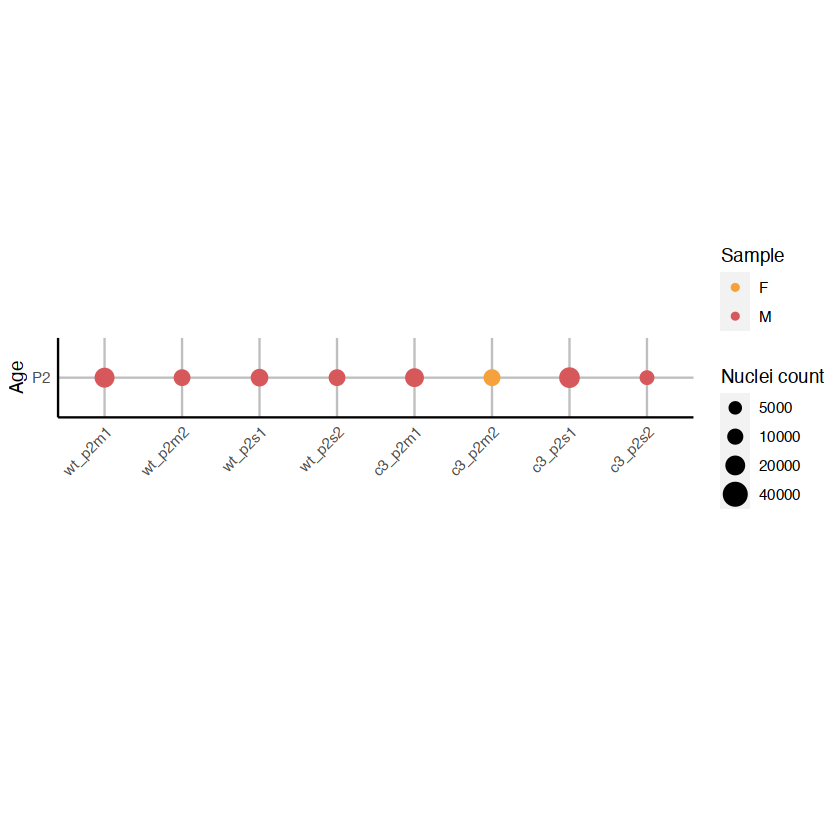

In [44]:
p <- ggplot(df) +
        geom_point(aes(x = GroupVar, y = StackVar.x, size = Count.x, color = StackVar.y)) +
        labs(x = ' ', y = 'Age', color = 'Sample', size = 'Nuclei count', shape = 'Sex') +
        theme(aspect.ratio = LU(df[,1][[1]])/LU(df[,2][[1]])) +
        scale_color_manual(values = mycol_10[3:1]) &
        scale_size(breaks = c(5e3, 1e4, 2e4, 4e4), limits = c(1e2, 4e4)) &
        guides(color = guide_legend(ncol = 1)) &
        theme(axis.ticks = element_blank(),
              axis.line = element_line(size = 0.5, color = 'black'),
              legend.background = element_blank(),
              panel.background = element_blank(),
              panel.grid.major = element_line(size = 0.5, color = 'grey75')) +
        RotatedAxis()
p
PlotPDF('03.dot.sample_sex_age_distribution', 10, 10)
p
dev.off()
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [45]:
Table(merge.srt$group1)
Table(merge.srt$group2)


wt_p2m1 wt_p2m2 wt_p2s1 wt_p2s2 c3_p2m1 c3_p2m2 c3_p2s1 c3_p2s2 
  20341   11547   13659   11554   17008   11851   22851    7305 


wt_p2m wt_p2s c3_p2m c3_p2s 
 31888  25213  28859  30156 

In [49]:
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
####  Organize meta data  ####
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~----
study_order <- c(
        '2023_NeoC3KO_RLi'
)
sample_order <- str_sort(U(merge.srt$sample))
method_order <- c(
        'Nucleus'
)
platform_order <- c(
        '10X'
)
protocol_order <- c(
        'GEX',
        'Multiome'
)
tissue_order <- str_sort(U(merge.srt$tissue))

sex_order <- c(
        'F',     
        'M'
)
age_order <- sort(U(merge.srt$age))


In [55]:
## Edit processed info
merge.srt$data_process <- 'CellBender'
#merge.srt$nCount_RAW <- NULL
#merge.srt$nFeature_RAW <- NULL
#merge.srt$nCount_CBN <- NULL
#merge.srt$nFeature_CBN <- NULL
#merge.srt$pct_mito_CBN <- NULL

## Set merged data ordering
merge.srt$study <- factor(merge.srt$study, levels = study_order)
merge.srt$sample <- factor(merge.srt$sample, levels = sample_order)
merge.srt$method <- factor(merge.srt$method, levels = method_order)
merge.srt$platform <- factor(merge.srt$platform, levels = platform_order)
merge.srt$protocol <- factor(merge.srt$protocol, levels = protocol_order)
merge.srt$tissue <- factor(merge.srt$tissue, levels = tissue_order)
merge.srt$sex <- factor(merge.srt$sex, levels = sex_order)
merge.srt$age <- factor(merge.srt$age, levels = age_order)
merge.srt$orig.ident <- NULL

In [56]:
## Checking basic stat of the merged dataset
stat <- c('study', 'group1', 'group2', 'sex')
col_choice <- list(mycol_10,
                   mycol_10,
                   mycol_10,
                   c(mycol_10[c(3:1)])
                   )
p.list <- list()
for(i in 1:4){
        data <- data.frame(group = factor(names(table(merge.srt@meta.data[, stat[i]])),
                                          levels = levels(merge.srt@meta.data[, stat[i]])),
                           value = table(merge.srt@meta.data[, stat[i]]))
        p.list[[i]] <- ggplot(data, aes(x = "", y = value.Freq, fill = group)) +
                geom_bar(stat = "identity", width = 1) +
                coord_polar("y", start = 0, direction = -1) +
                labs(title = stat[i]) +
                scale_fill_manual(values = col_choice[[i]]) +
                WhiteBackground() +
                NoAxes() +
                theme(aspect.ratio = 1, legend.title = element_blank())
}
PlotPDF('04.merged_consensus.meta_stat', 5, 5, onefile = T)
p.list
dev.off()

[[1]]

[[2]]

[[3]]

[[4]]


pdf 
  2

In [57]:
merge.srt <- DietSeurat(merge.srt, assays = c('RNA', 'ATAC'), dimreducs = names(merge.srt@reductions))
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
saveRDS(merge.srt@meta.data, 'integrated/PART02.merged.srt_meta.rds')
saveRDS(merge.srt, 'integrated/PART02.merged.srt.rds')
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



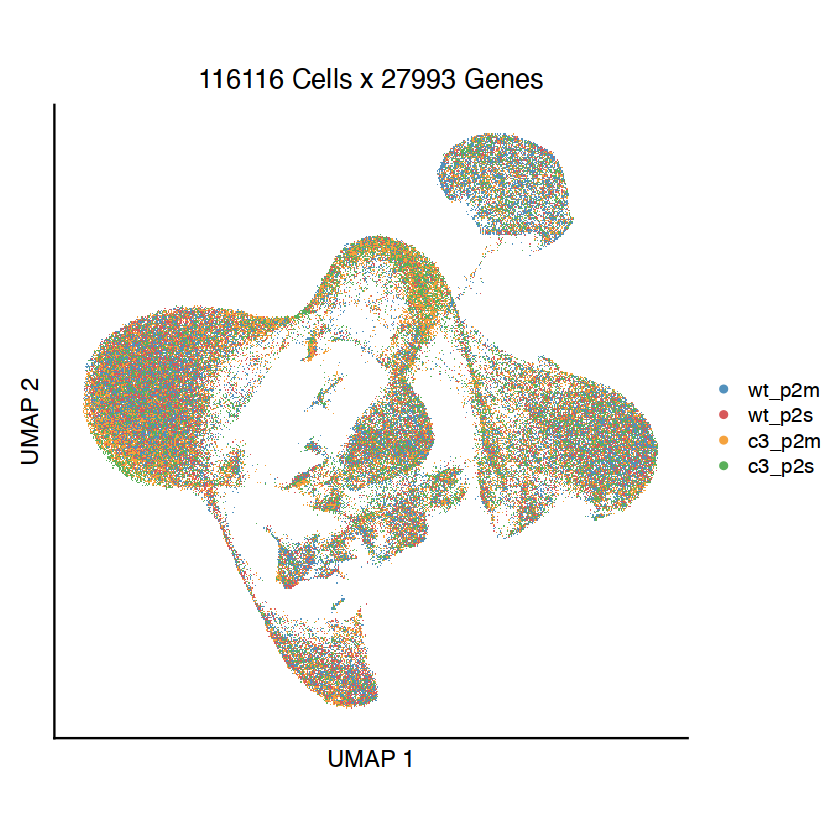

In [58]:
DimPlot2(merge.srt, group.by = 'group2', reduction = 'hmn_umap',
                       cols = mycol_10, label = F, pt.size = 0.1) +
                labs(x = "UMAP 1", y = "UMAP 2",
                     title = paste0(ncol(merge.srt), " Cells x ", nrow(merge.srt), " Genes")) +
                guides(col = guide_legend(ncol = 1))